# Statoil/C-CORE Iceberg Classifier Challenge [[link](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)]

Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

In this exercise I will build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

## Import dependencies & create constants

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from img_preprocessing import random_rotation, random_translation, random_zoom, random_channel_shift, flip_axis
from utils import show_imgs, Inception, count_params, aug_img

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Conv2D, GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Input, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD

PATH = '/home/ubuntu/iceberg/'

Using TensorFlow backend.


## Get data

In [2]:
TEST_SIZE = 0.2

def getData(path):
    df = pd.read_json(path)
    x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])
    x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    x_band = np.stack([x_band1, x_band2], axis=3)
    x_angle = np.array(df['inc_angle'].replace('na', 0).astype(float).fillna(0.0))
    if 'is_iceberg' in df.columns:
        y = np.array(df['is_iceberg'])
        return x_band, x_angle, y
    else:
        ids = df['id'].values
        return x_band, x_angle, ids

(x_train_band, x_valid_band, x_train_angle, x_valid_angle, y_train, y_valid) = train_test_split(*getData(PATH+'data/train.json'), random_state=7300, test_size=TEST_SIZE)

x_test_band, x_test_angle, test_ids = getData(PATH+'data/test.json')

# some models recieved augmentation parameters as input
x_valid_meta = np.array([[0, 0, 0, angle] for angle in x_valid_angle])
x_test_meta = np.array([[0, 0, 0, angle] for angle in x_test_angle])

In [3]:
print('Test samples:       %i'%len(x_test_band))
print('Training samples:   %i'%len(x_train_band))
print('Validation samples: %i'%len(x_valid_band))
print('\n(not much here, but we\'ll manage)')

Test samples:       8424
Training samples:   1283
Validation samples: 321

(not much here, but we'll manage)


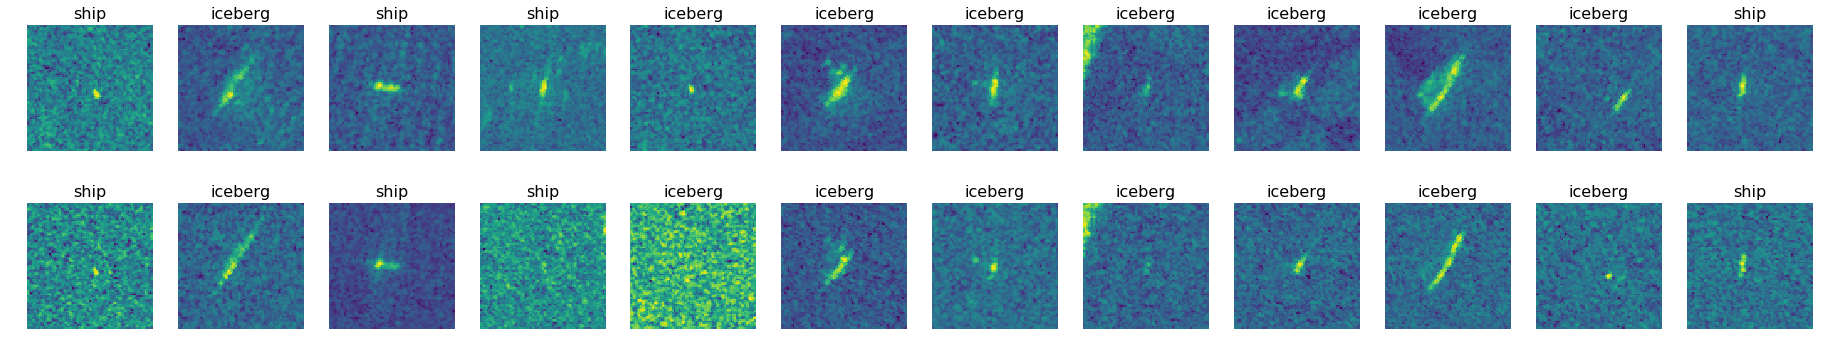

In [4]:
show_imgs(x_train_band[:12], labels=['iceberg' if v == 1 else 'ship' for v in y_train[:12]])

## Experiment with architecture

### 4-layer CNN (32 to 64 filters)

Let's start with something VGG-inspired, a good starting point for image recognition.

NB: without Inception modules accuracy hovered around 75%

In [6]:
LEARNING_RATE = 0.0001
ACTIVATION = 'elu'
BN_MOMENT = 0.9
CONV_DROPOUT = 0.2
DENSE_DROPOUT = 0.5

input_band = Input(shape=[75, 75, 2], name="band")
input_angle = Input(shape=[1], name="angle")

model = BatchNormalization(momentum=BN_MOMENT)(input_band)

model = Inception(model, 32)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Inception(model, 32)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Dropout(CONV_DROPOUT)(model)
model = MaxPooling2D((2,2))(model)

model = Inception(model, 64)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Inception(model, 64)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Dropout(CONV_DROPOUT)(model)
model = AveragePooling2D((2,2))(model)

model = Flatten()(model)

model = Concatenate()([model, BatchNormalization(momentum=BN_MOMENT)(input_angle)])

model = Dense(256, activation=ACTIVATION)(model)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Dropout(DENSE_DROPOUT)(model)

model = Dense(64, activation=ACTIVATION)(model)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Dropout(DENSE_DROPOUT)(model)

output = Dense(1, activation='sigmoid')(model)

model = Model([input_band, input_angle], output)

optimizer = Adam(lr=LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print('Trainable params: {:,}'.format(count_params(model)))

Trainable params: 21,947,015


In [7]:
model.fit([x_train_band, x_train_angle], y_train, epochs=5, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/4_layer_cnn_5.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/5
1283/1283 [==============================] - 30s - loss: 0.7577 - acc: 0.6477 - val_loss: 0.4407 - val_acc: 0.7944
Epoch 2/5
1283/1283 [==============================] - 24s - loss: 0.5585 - acc: 0.7443 - val_loss: 0.3698 - val_acc: 0.8255
Epoch 3/5
1283/1283 [==============================] - 25s - loss: 0.4886 - acc: 0.7685 - val_loss: 0.4365 - val_acc: 0.7882
Epoch 4/5
1283/1283 [==============================] - 25s - loss: 0.3640 - acc: 0.8527 - val_loss: 0.2598 - val_acc: 0.8972
Epoch 5/5
1283/1283 [==============================] - 25s - loss: 0.2751 - acc: 0.8831 - val_loss: 0.3429 - val_acc: 0.8474


In [8]:
model = load_model(PATH+'models/4_layer_cnn_5.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=5, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/4_layer_cnn_10.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/5
1283/1283 [==============================] - 25s - loss: 0.2183 - acc: 0.9189 - val_loss: 0.4259 - val_acc: 0.8224
Epoch 2/5
1283/1283 [==============================] - 25s - loss: 0.1944 - acc: 0.9166 - val_loss: 0.3193 - val_acc: 0.8692
Epoch 3/5
1283/1283 [==============================] - 25s - loss: 0.2804 - acc: 0.8831 - val_loss: 0.3469 - val_acc: 0.8723
Epoch 4/5
1283/1283 [==============================] - 25s - loss: 0.2939 - acc: 0.8784 - val_loss: 0.2341 - val_acc: 0.9034
Epoch 5/5
1283/1283 [==============================] - 25s - loss: 0.2179 - acc: 0.9080 - val_loss: 0.2458 - val_acc: 0.8910


### 2 Layer CNN (128 filters)

The ships/icebergs have little heirachial structure - the primary use case for deep networks. Maybe a shallow network with more filters per layer would be better suited for this challenge?

I introduced a global pooling layer as the ship's/iceberg's location within the image doesn't seem useful & might lead to overfitting.

In [9]:
LEARNING_RATE = 0.0001
ACTIVATION = 'elu'
BN_MOMENT = 0.9
CONV_DROPOUT = 0.4
DENSE_DROPOUT = 0.5

input_band = Input(shape=[75, 75, 2], name="band")
input_angle = Input(shape=[1], name="angle")

model = BatchNormalization(momentum=BN_MOMENT)(input_band)

model = Inception(model, 128)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Inception(model, 128)
model = Dropout(CONV_DROPOUT)(model)
model = GlobalMaxPooling2D()(model)
model = BatchNormalization(momentum=BN_MOMENT)(model)

model_angle = BatchNormalization(momentum=BN_MOMENT)(input_angle)
model_angle = Dense(10)(model_angle)

model = Concatenate()([model, model_angle])

model = Dense(64, activation=ACTIVATION)(model)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Dropout(DENSE_DROPOUT)(model)

output = Dense(1, activation='sigmoid')(model)

model = Model([input_band, input_angle], output)

optimizer = Adam(lr=LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print('Trainable params: {:,}'.format(count_params(model)))

Trainable params: 1,940,891


In [10]:
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/2_layer_cnn_1.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 68s - loss: 0.5207 - acc: 0.7779 - val_loss: 0.8605 - val_acc: 0.5763


In [12]:
model = load_model(PATH+'models/2_layer_cnn_1.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/2_layer_cnn_2.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 63s - loss: 0.3959 - acc: 0.8231 - val_loss: 0.3289 - val_acc: 0.8692


In [13]:
model = load_model(PATH+'models/2_layer_cnn_2.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/2_layer_cnn_3.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 63s - loss: 0.3410 - acc: 0.8574 - val_loss: 0.3378 - val_acc: 0.8318


In [14]:
model = load_model(PATH+'models/2_layer_cnn_3.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/2_layer_cnn_4.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 63s - loss: 0.3115 - acc: 0.8698 - val_loss: 0.2527 - val_acc: 0.9190


In [15]:
model = load_model(PATH+'models/2_layer_cnn_4.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/2_layer_cnn_5.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 63s - loss: 0.3019 - acc: 0.8870 - val_loss: 0.2795 - val_acc: 0.8910


### Capsule-based CNN

Inception modules are believed to improve model performance by reducing information loss due to max pooling. & although nobody seems to know what capsule learning is, some suspect it'd do even better than Inception modules. I tried combining several convolutional "towers" of varying depth to test the idea (it didn't work out).

In [4]:
LEARNING_RATE = 0.0001
ACTIVATION = 'elu'
BN_MOMENT = 0.9
CONV_DROPOUT = 0.4
DENSE_DROPOUT = 0.5

input_band = Input(shape=[75, 75, 2], name="band")
input_angle = Input(shape=[1], name="angle")

model = BatchNormalization(momentum=BN_MOMENT)(input_band)

def InceptionCapsule(model, height=1):
    for i in range(height):
        model = Inception(model, 16)
    model = BatchNormalization(momentum=BN_MOMENT)(model)
    model = Dropout(CONV_DROPOUT)(model)
    return model

capsules = [
    InceptionCapsule(model, 1),
    InceptionCapsule(model, 1),
    InceptionCapsule(model, 2),
    InceptionCapsule(model, 2),
    InceptionCapsule(model, 3),
    InceptionCapsule(model, 3)
]

model = Concatenate(axis=3)(capsules)
model = GlobalMaxPooling2D()(model)
model = BatchNormalization(momentum=BN_MOMENT)(model)

model_angle = BatchNormalization(momentum=BN_MOMENT)(input_angle)
model_angle = Dense(10)(model_angle)

model = Concatenate()([model, model_angle])

model = Dense(64, activation=ACTIVATION)(model)
model = BatchNormalization(momentum=BN_MOMENT)(model)
model = Dropout(DENSE_DROPOUT)(model)

output = Dense(1, activation='sigmoid')(model)

model = Model([input_band, input_angle], output)

optimizer = Adam(lr=LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print('Trainable params: {:,}'.format(count_params(model)))

Trainable params: 208,667


In [5]:
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/capsule_1.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 62s - loss: 0.6563 - acc: 0.6781 - val_loss: 0.6894 - val_acc: 0.5888


In [6]:
model = load_model(PATH+'models/capsule_1.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/capsule_2.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 56s - loss: 0.4844 - acc: 0.7818 - val_loss: 0.4031 - val_acc: 0.8411


In [7]:
model = load_model(PATH+'models/capsule_2.h5')
model.fit([x_train_band, x_train_angle], y_train, epochs=1, validation_data=([x_valid_band, x_valid_angle], y_valid), batch_size=32)
model.save(PATH+'models/capsule_3.h5')

Train on 1283 samples, validate on 321 samples
Epoch 1/1
1283/1283 [==============================] - 56s - loss: 0.4343 - acc: 0.8012 - val_loss: 0.3851 - val_acc: 0.8380


## Data augmentation & hyperparameter tuning

Of the three models the 2-layer CNN is best. To reduce training time I dropped from 128 to 64 filters, and compensated by concatenating the output of both layers (like a very shallow ResNet).

We don't have much training data so I'm going to start by investigating data augmentation.

### Batch generator

In [6]:
def get_batches(imgs, angles, labels, batch_size=32, rotate=None, translate=None, zoom=None, channel_shift=None, flip=None):
    
    indices = list(range(len(labels)))
    
    while True:
        
        np.random.shuffle(indices)
        
        imgs = np.copy(imgs)
        angles = np.copy(angles)
        labels = np.copy(labels)
        
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            
            img_batch = []
            meta_batch = []
            label_batch = labels[indices[start:end]]
            
            for _i in range(start, end):
                i = indices[_i]
                
                img, meta = aug_img(imgs[i], rotate=rotate, translate=translate, zoom=zoom, channel_shift=channel_shift, flip=flip)
                meta.append(angles[i])

                img_batch.append(img)
                meta_batch.append(meta)
            
            meta_batch = np.array(meta_batch, np.float32)
            img_batch = np.array(img_batch, np.float32)
            
            yield [img_batch, meta_batch], label_batch

### Modelling

In [5]:
LEARNING_RATE = 0.0001
ACTIVATION = 'elu'
BN_MOMENT = 0.9
CONV_DROPOUT = 0.
DENSE_DROPOUT = 0.

def get_model(optimizer=Adam(lr=LEARNING_RATE)):
    input_band = Input(shape=[75, 75, 2], name="band")
    input_meta = Input(shape=[4], name="meta")

    model = BatchNormalization(momentum=BN_MOMENT)(input_band)

    model = Inception(model, 64)
    model = BatchNormalization(momentum=BN_MOMENT)(model)
    model_l2 = Inception(model, 64)
    model = Concatenate(axis=3)([model, model_l2])
    model = Dropout(CONV_DROPOUT)(model)
    model = GlobalMaxPooling2D()(model)
    model = BatchNormalization(momentum=BN_MOMENT)(model)

    model_angle = BatchNormalization(momentum=BN_MOMENT)(input_meta)
    model_angle = Dense(16)(model_angle)

    model = Concatenate()([model, model_angle])

    model = Dense(64, activation=ACTIVATION)(model)
    model = BatchNormalization(momentum=BN_MOMENT)(model)
    model = Dropout(DENSE_DROPOUT)(model)

    output = Dense(1, activation='sigmoid')(model)

    model = Model([input_band, input_meta], output)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

model = get_model()

print('Trainable params: {:,}'.format(count_params(model)))

Trainable params: 513,117


In [ ]:
model = get_model()
model.fit_generator(
    get_batches(x_train_band, x_train_angle, y_train, batch_size=32),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/32), epochs=10
)
model.save(PATH+'models/aug_cnn_10.h5')

Epoch 1/10
41/41 [==============================] - 31s - loss: 0.4688 - acc: 0.7660 - val_loss: 0.5324 - val_acc: 0.7290
Epoch 2/10
41/41 [==============================] - 29s - loss: 0.2765 - acc: 0.8993 - val_loss: 0.2286 - val_acc: 0.9221
Epoch 3/10
41/41 [==============================] - 29s - loss: 0.2395 - acc: 0.9002 - val_loss: 0.2273 - val_acc: 0.9252
Epoch 4/10
41/41 [==============================] - 29s - loss: 0.1906 - acc: 0.9344 - val_loss: 0.2404 - val_acc: 0.9065
Epoch 5/10
41/41 [==============================] - 29s - loss: 0.1867 - acc: 0.9341 - val_loss: 0.2400 - val_acc: 0.9065
Epoch 6/10
41/41 [==============================] - 29s - loss: 0.1425 - acc: 0.9600 - val_loss: 0.2281 - val_acc: 0.9252
Epoch 7/10
41/41 [==============================] - 29s - loss: 0.1593 - acc: 0.9608 - val_loss: 0.2293 - val_acc: 0.9097
Epoch 8/10
11/41 [=======>......................] - ETA: 19s - loss: 0.1369 - acc: 0.9574

### Searching for augmentation parameters

For each of 5 augmentations I tried 3 variants, & picked the values where training loss decreased reliably throughout training & validation loss did not exceed training loss (underfitting).

In [28]:
def try_finetuning(epochs=7, rotate=None, translate=None, zoom=None, channel_shift=None, flip=None):
    model = get_model()
    model.fit_generator(
        get_batches(x_train_band, x_train_angle, y_train, batch_size=32,
                    rotate=rotate, translate=translate, zoom=zoom, channel_shift=channel_shift, flip=flip),
        validation_data=([x_valid_band, x_valid_meta], y_valid),
        steps_per_epoch=np.ceil(len(y_train)/32), epochs=epochs
    )

#### Rotation

In [14]:
try_finetuning(rotate=20)

Epoch 1/7
41/41 [==============================] - 27s - loss: 0.4518 - acc: 0.7689 - val_loss: 0.4507 - val_acc: 0.7632
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3259 - acc: 0.8609 - val_loss: 0.2348 - val_acc: 0.9190
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2893 - acc: 0.8818 - val_loss: 0.2144 - val_acc: 0.9283
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2683 - acc: 0.8917 - val_loss: 0.2181 - val_acc: 0.9252
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2500 - acc: 0.8899 - val_loss: 0.2182 - val_acc: 0.9315
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2403 - acc: 0.9074 - val_loss: 0.2236 - val_acc: 0.9221
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2220 - acc: 0.9123 - val_loss: 0.2051 - val_acc: 0.9346


In [15]:
try_finetuning(rotate=90)

Epoch 1/7
41/41 [==============================] - 27s - loss: 0.4714 - acc: 0.7712 - val_loss: 0.3667 - val_acc: 0.8536
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3661 - acc: 0.8311 - val_loss: 0.2797 - val_acc: 0.8879
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.3539 - acc: 0.8255 - val_loss: 0.2712 - val_acc: 0.8972
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.3708 - acc: 0.8388 - val_loss: 0.3134 - val_acc: 0.8847
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.3159 - acc: 0.8673 - val_loss: 0.2486 - val_acc: 0.9097
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.3533 - acc: 0.8259 - val_loss: 0.2538 - val_acc: 0.9128
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.3100 - acc: 0.8833 - val_loss: 0.2270 - val_acc: 0.9190


In [16]:
try_finetuning(rotate=360)

Epoch 1/7
41/41 [==============================] - 27s - loss: 0.5405 - acc: 0.7285 - val_loss: 0.9491 - val_acc: 0.6075
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3912 - acc: 0.8182 - val_loss: 0.2961 - val_acc: 0.8972
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.3528 - acc: 0.8426 - val_loss: 0.2722 - val_acc: 0.9097
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.3406 - acc: 0.8559 - val_loss: 0.2822 - val_acc: 0.8879
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.3199 - acc: 0.8589 - val_loss: 0.2493 - val_acc: 0.9097
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.3494 - acc: 0.8594 - val_loss: 0.2648 - val_acc: 0.9003
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.3265 - acc: 0.8563 - val_loss: 0.2524 - val_acc: 0.9097


#### Translation

In [17]:
try_finetuning(translate=0.05)

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4377 - acc: 0.7865 - val_loss: 0.4757 - val_acc: 0.7352
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.2846 - acc: 0.8899 - val_loss: 0.2561 - val_acc: 0.9097
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2048 - acc: 0.9268 - val_loss: 0.2021 - val_acc: 0.9315
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.1899 - acc: 0.9246 - val_loss: 0.2774 - val_acc: 0.8692
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.1624 - acc: 0.9344 - val_loss: 0.2296 - val_acc: 0.9034
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.1333 - acc: 0.9588 - val_loss: 0.2261 - val_acc: 0.9190
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.1259 - acc: 0.9588 - val_loss: 0.2248 - val_acc: 0.9065


In [18]:
try_finetuning(translate=0.2)

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4330 - acc: 0.7842 - val_loss: 0.3995 - val_acc: 0.7819
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.2872 - acc: 0.8761 - val_loss: 0.2731 - val_acc: 0.8847
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2549 - acc: 0.9013 - val_loss: 0.2345 - val_acc: 0.9128
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2271 - acc: 0.9135 - val_loss: 0.2210 - val_acc: 0.9190
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2189 - acc: 0.9089 - val_loss: 0.2137 - val_acc: 0.9221
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.1966 - acc: 0.9222 - val_loss: 0.2367 - val_acc: 0.8879
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2034 - acc: 0.9170 - val_loss: 0.2078 - val_acc: 0.9190


In [19]:
try_finetuning(translate=0.5)

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4662 - acc: 0.7629 - val_loss: 0.2780 - val_acc: 0.8785
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3316 - acc: 0.8525 - val_loss: 0.2344 - val_acc: 0.9190
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2694 - acc: 0.8876 - val_loss: 0.1991 - val_acc: 0.9252
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2728 - acc: 0.8746 - val_loss: 0.2150 - val_acc: 0.9128
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2487 - acc: 0.8944 - val_loss: 0.2756 - val_acc: 0.8723
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2430 - acc: 0.9051 - val_loss: 0.2038 - val_acc: 0.9252
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2520 - acc: 0.9028 - val_loss: 0.2311 - val_acc: 0.9128


#### Zooming

In [20]:
try_finetuning(zoom=(0.95, 1.05))

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4876 - acc: 0.7583 - val_loss: 0.4008 - val_acc: 0.8037
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.2838 - acc: 0.8864 - val_loss: 0.2254 - val_acc: 0.9221
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2520 - acc: 0.9043 - val_loss: 0.2100 - val_acc: 0.9252
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2387 - acc: 0.9055 - val_loss: 0.2264 - val_acc: 0.9097
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.1864 - acc: 0.9268 - val_loss: 0.2195 - val_acc: 0.9097
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.1614 - acc: 0.9504 - val_loss: 0.2158 - val_acc: 0.9159
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.1497 - acc: 0.9394 - val_loss: 0.2004 - val_acc: 0.9221


In [21]:
try_finetuning(zoom=(0.8, 1.2))

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4418 - acc: 0.7918 - val_loss: 0.3045 - val_acc: 0.9065
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3211 - acc: 0.8543 - val_loss: 0.2616 - val_acc: 0.9034
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2716 - acc: 0.8853 - val_loss: 0.2179 - val_acc: 0.9252
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2658 - acc: 0.8944 - val_loss: 0.2331 - val_acc: 0.9128
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2864 - acc: 0.8914 - val_loss: 0.1994 - val_acc: 0.9439
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2388 - acc: 0.9085 - val_loss: 0.2289 - val_acc: 0.9190
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2212 - acc: 0.9176 - val_loss: 0.2175 - val_acc: 0.9190


In [22]:
try_finetuning(zoom=(0.6, 1.4))

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4854 - acc: 0.7527 - val_loss: 0.4833 - val_acc: 0.7321
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3576 - acc: 0.8360 - val_loss: 0.2552 - val_acc: 0.9315
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.3327 - acc: 0.8434 - val_loss: 0.2197 - val_acc: 0.9283
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.3230 - acc: 0.8586 - val_loss: 0.2249 - val_acc: 0.9190
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2911 - acc: 0.8749 - val_loss: 0.2270 - val_acc: 0.9128
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2935 - acc: 0.8883 - val_loss: 0.1952 - val_acc: 0.9065
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2562 - acc: 0.8925 - val_loss: 0.1925 - val_acc: 0.9252


#### Channel Shift

In [23]:
try_finetuning(channel_shift=0.1)

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4660 - acc: 0.7892 - val_loss: 0.3797 - val_acc: 0.8474
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3022 - acc: 0.8822 - val_loss: 0.2336 - val_acc: 0.9003
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2327 - acc: 0.9097 - val_loss: 0.2062 - val_acc: 0.9315
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.1994 - acc: 0.9321 - val_loss: 0.2178 - val_acc: 0.9159
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.1977 - acc: 0.9254 - val_loss: 0.2273 - val_acc: 0.9159
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.1735 - acc: 0.9493 - val_loss: 0.2596 - val_acc: 0.8816
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.1470 - acc: 0.9527 - val_loss: 0.3224 - val_acc: 0.8692


In [24]:
try_finetuning(channel_shift=0.2)

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4197 - acc: 0.7945 - val_loss: 0.6003 - val_acc: 0.6355
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.2727 - acc: 0.8838 - val_loss: 0.2191 - val_acc: 0.9128
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2147 - acc: 0.9245 - val_loss: 0.2286 - val_acc: 0.9034
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.1826 - acc: 0.9359 - val_loss: 0.2036 - val_acc: 0.9190
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.1335 - acc: 0.9657 - val_loss: 0.1954 - val_acc: 0.9283
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.1262 - acc: 0.9600 - val_loss: 0.2468 - val_acc: 0.9065
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.1396 - acc: 0.9581 - val_loss: 0.2593 - val_acc: 0.8972


In [25]:
try_finetuning(channel_shift=0.5)

Epoch 1/7
41/41 [==============================] - 28s - loss: 0.4338 - acc: 0.8017 - val_loss: 0.2925 - val_acc: 0.8754
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.2717 - acc: 0.8929 - val_loss: 0.2121 - val_acc: 0.9128
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2358 - acc: 0.9005 - val_loss: 0.2079 - val_acc: 0.9221
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2033 - acc: 0.9158 - val_loss: 0.2335 - val_acc: 0.9097
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2209 - acc: 0.9200 - val_loss: 0.1964 - val_acc: 0.9252
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.1690 - acc: 0.9436 - val_loss: 0.2026 - val_acc: 0.9097
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.1442 - acc: 0.9535 - val_loss: 0.1847 - val_acc: 0.9252


#### Flip

In [29]:
try_finetuning(flip=(True, True))

Epoch 1/7
41/41 [==============================] - 29s - loss: 0.4856 - acc: 0.7640 - val_loss: 0.4040 - val_acc: 0.8162
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3514 - acc: 0.8403 - val_loss: 0.2893 - val_acc: 0.8847
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.3015 - acc: 0.8738 - val_loss: 0.2232 - val_acc: 0.9252
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2885 - acc: 0.8697 - val_loss: 0.2766 - val_acc: 0.8879
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2576 - acc: 0.9001 - val_loss: 0.2159 - val_acc: 0.9034
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2408 - acc: 0.9031 - val_loss: 0.2221 - val_acc: 0.9128
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2405 - acc: 0.9021 - val_loss: 0.2270 - val_acc: 0.8972


In [32]:
try_finetuning(flip=(True, False))

Epoch 1/7
41/41 [==============================] - 29s - loss: 0.4956 - acc: 0.7667 - val_loss: 0.4231 - val_acc: 0.7975
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3183 - acc: 0.8681 - val_loss: 0.2822 - val_acc: 0.8660
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2704 - acc: 0.8902 - val_loss: 0.2409 - val_acc: 0.9034
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2541 - acc: 0.9005 - val_loss: 0.2369 - val_acc: 0.8941
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2276 - acc: 0.9161 - val_loss: 0.2223 - val_acc: 0.9097
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2222 - acc: 0.9143 - val_loss: 0.2148 - val_acc: 0.9003
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2062 - acc: 0.9245 - val_loss: 0.2480 - val_acc: 0.9128


In [33]:
try_finetuning(flip=(False, True))

Epoch 1/7
41/41 [==============================] - 29s - loss: 0.4600 - acc: 0.7701 - val_loss: 0.5125 - val_acc: 0.7009
Epoch 2/7
41/41 [==============================] - 27s - loss: 0.3231 - acc: 0.8658 - val_loss: 0.2649 - val_acc: 0.8972
Epoch 3/7
41/41 [==============================] - 27s - loss: 0.2920 - acc: 0.8773 - val_loss: 0.2433 - val_acc: 0.9190
Epoch 4/7
41/41 [==============================] - 27s - loss: 0.2484 - acc: 0.8948 - val_loss: 0.2417 - val_acc: 0.9128
Epoch 5/7
41/41 [==============================] - 27s - loss: 0.2539 - acc: 0.8972 - val_loss: 0.2629 - val_acc: 0.8972
Epoch 6/7
41/41 [==============================] - 27s - loss: 0.2348 - acc: 0.9082 - val_loss: 0.2293 - val_acc: 0.9128
Epoch 7/7
41/41 [==============================] - 27s - loss: 0.2345 - acc: 0.9092 - val_loss: 0.2395 - val_acc: 0.9128


#### All together!

In [34]:
model = get_model()
model.fit_generator(
    get_batches(x_train_band, x_train_angle, y_train, batch_size=32,
                rotate=20, translate=0.2, zoom=(0.7,1.3), channel_shift=0.4, flip=None),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/32), epochs=20
)
model.save(PATH+'models/aug_cnn_20_tuned.h5')
model.save_weights(PATH+'models/aug_cnn_20_tuned_weights.h5')

Epoch 1/20
41/41 [==============================] - 29s - loss: 0.4682 - acc: 0.7759 - val_loss: 0.4006 - val_acc: 0.8037
Epoch 2/20
41/41 [==============================] - 27s - loss: 0.3453 - acc: 0.8437 - val_loss: 0.2512 - val_acc: 0.9190
Epoch 3/20
41/41 [==============================] - 27s - loss: 0.3352 - acc: 0.8597 - val_loss: 0.2421 - val_acc: 0.9221
Epoch 4/20
41/41 [==============================] - 27s - loss: 0.3302 - acc: 0.8589 - val_loss: 0.2208 - val_acc: 0.9221
Epoch 5/20
41/41 [==============================] - 27s - loss: 0.2817 - acc: 0.8856 - val_loss: 0.2356 - val_acc: 0.9034
Epoch 6/20
41/41 [==============================] - 27s - loss: 0.3004 - acc: 0.8738 - val_loss: 0.2597 - val_acc: 0.9128
Epoch 7/20
41/41 [==============================] - 27s - loss: 0.2948 - acc: 0.8891 - val_loss: 0.2229 - val_acc: 0.9315
Epoch 8/20
41/41 [==============================] - 27s - loss: 0.3023 - acc: 0.8754 - val_loss: 0.2103 - val_acc: 0.9159
Epoch 9/20
41/41 [======

The loss seems to start fluctuating after 10 epochs - is this a sign we can improve by lowering the learning rate / using a simpler optimizer?

In [40]:
model = get_model(optimizer=SGD(lr=0.00001))
model.load_weights(PATH+'models/aug_cnn_20_tuned_weights.h5')
model.fit_generator(
    get_batches(x_train_band, x_train_angle, y_train, batch_size=64,
                rotate=20, translate=0.2, zoom=(0.7,1.3), channel_shift=0.4, flip=None),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/64), epochs=10
)
model.save(PATH+'models/aug_cnn_30_tuned.h5')

Epoch 1/10
21/21 [==============================] - 31s - loss: 0.2272 - acc: 0.9073 - val_loss: 0.1900 - val_acc: 0.9252
Epoch 2/10
21/21 [==============================] - 26s - loss: 0.2591 - acc: 0.9095 - val_loss: 0.1963 - val_acc: 0.9190
Epoch 3/10
21/21 [==============================] - 26s - loss: 0.2242 - acc: 0.9016 - val_loss: 0.1885 - val_acc: 0.9283
Epoch 4/10
21/21 [==============================] - 26s - loss: 0.2371 - acc: 0.9065 - val_loss: 0.1939 - val_acc: 0.9283
Epoch 5/10
21/21 [==============================] - 27s - loss: 0.2099 - acc: 0.9239 - val_loss: 0.1949 - val_acc: 0.9315
Epoch 6/10
21/21 [==============================] - 26s - loss: 0.1914 - acc: 0.9329 - val_loss: 0.1927 - val_acc: 0.9346
Epoch 7/10
21/21 [==============================] - 26s - loss: 0.1966 - acc: 0.9269 - val_loss: 0.1903 - val_acc: 0.9283
Epoch 8/10
21/21 [==============================] - 26s - loss: 0.2099 - acc: 0.9165 - val_loss: 0.1909 - val_acc: 0.9346
Epoch 9/10
21/21 [======

## Inspecting results & pseudo-labels

We're borderline underfitting with our data augmentation. Let's skip dropout & move to pseudo-labelling - there's a lot of test data we might be able to learn from.

In [8]:
model = load_model(PATH+'models/aug_cnn_30_tuned.h5')

### Get labels & check distribution of predictions

Our predictions are soft - we can skip knowledge distillation.

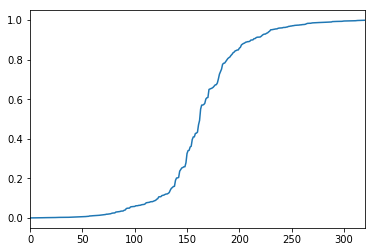

In [9]:
valid_predictions = model.predict([x_valid_band, x_valid_meta])[:,0]

pd.Series(valid_predictions).sort_values().reset_index(drop=True).plot()

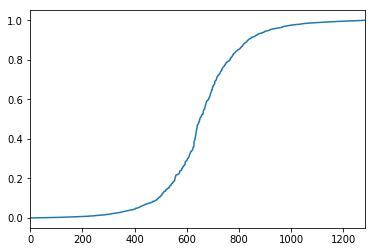

In [10]:
x_train_meta = np.array([[0, 0, 0, angle] for angle in x_train_angle])

train_predictions = model.predict([x_train_band, x_train_meta])[:,0]

pd.Series(train_predictions).sort_values().reset_index(drop=True).plot()

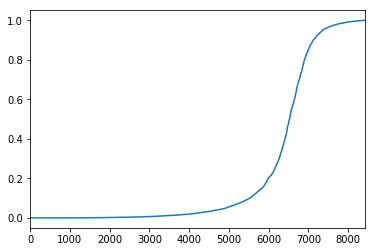

In [18]:
test_predictions = model.predict([x_test_band, x_test_meta])[:,0]
np.save(PATH+'/models/aug_cnn_30_tuned', test_predictions)

pd.Series(test_predictions).sort_values().reset_index(drop=True).plot()

### Sample predictions

```
0 = ship predicted
1 = iceberg
0.5 = not sure
```

In [11]:
def sample_predictions(idx):
    show_imgs(x_train_band[idx], labels=['%.3f'%v for v in train_predictions[idx]])

correct = np.where(np.isclose(train_predictions,y_train,0,0.5))[0]
wrong = np.where(np.invert(np.isclose(train_predictions,y_train,0,0.5)))[0]

#### Random (and correct)

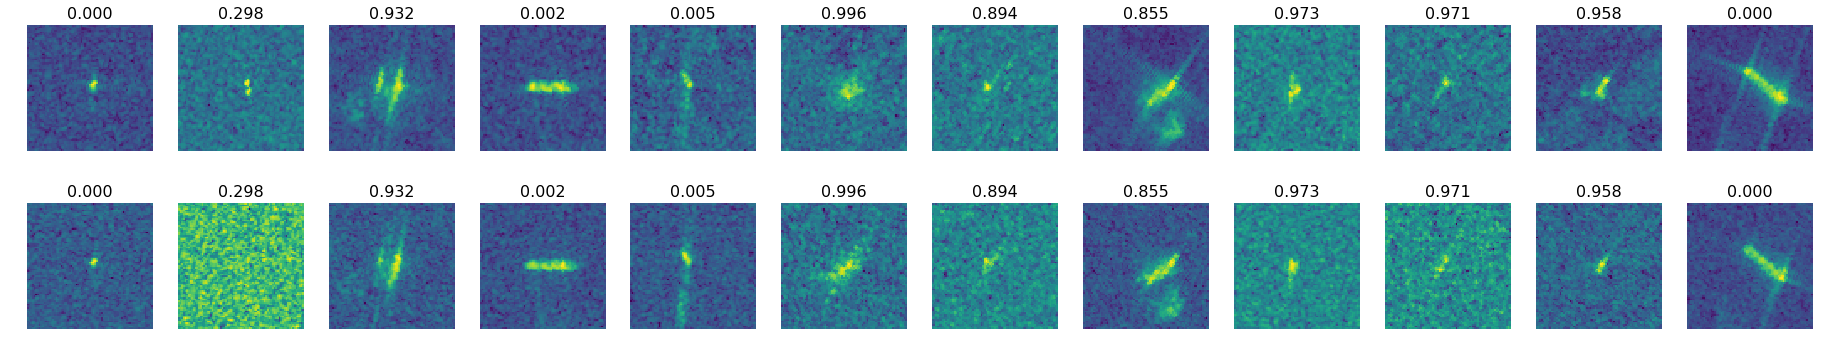

In [12]:
sample_predictions(np.random.permutation(correct)[:12])

#### Random (and wrong)

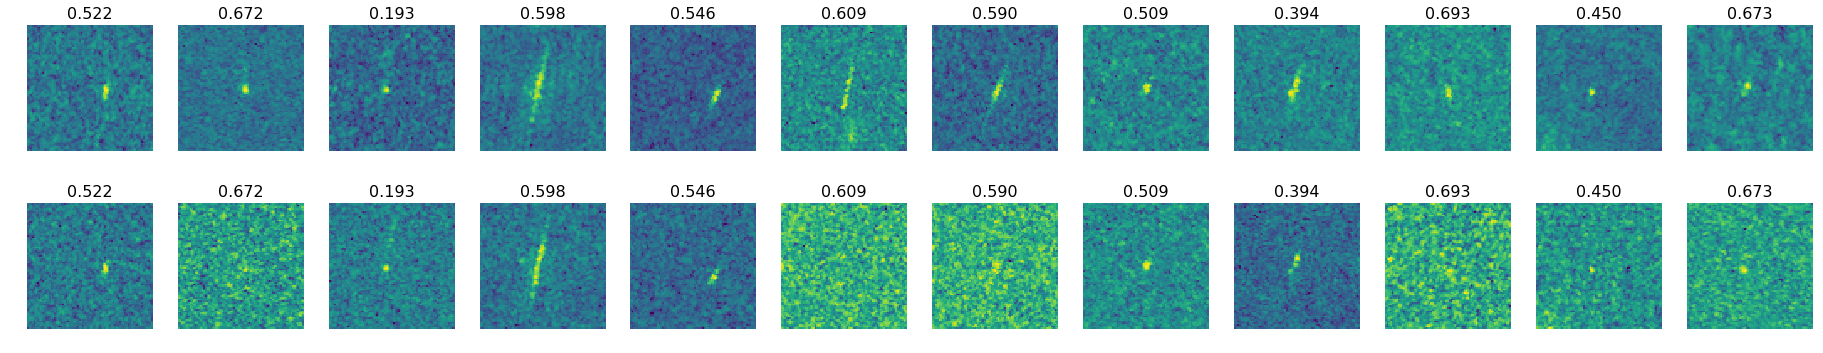

In [13]:
sample_predictions(np.random.permutation(wrong)[:12])

#### Most confident (and correct)

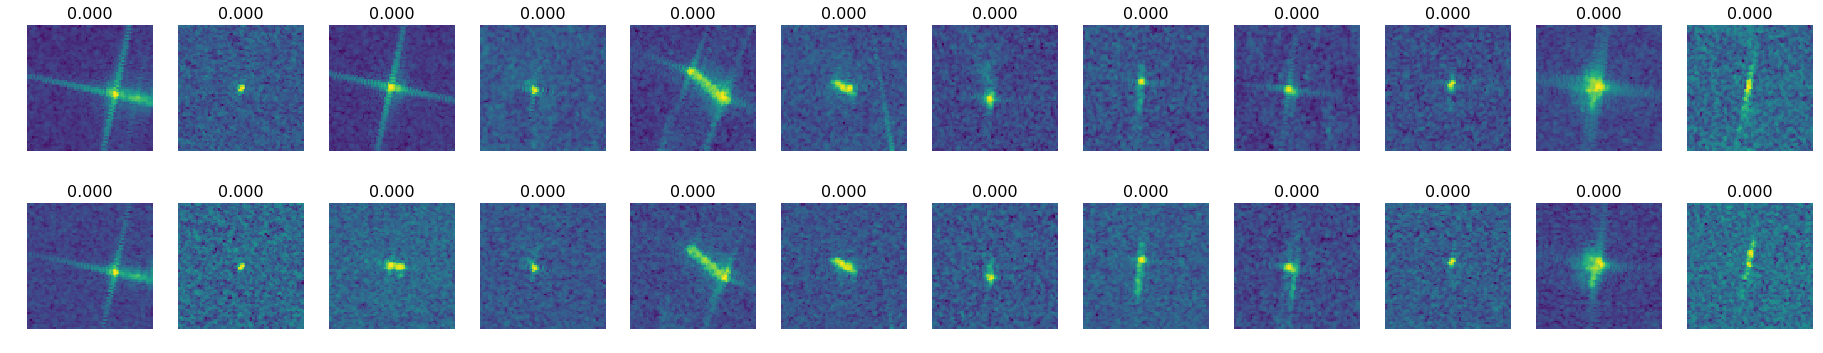

In [14]:
sample_predictions(np.argsort(train_predictions)[np.isin(np.argsort(train_predictions), correct)][:12])

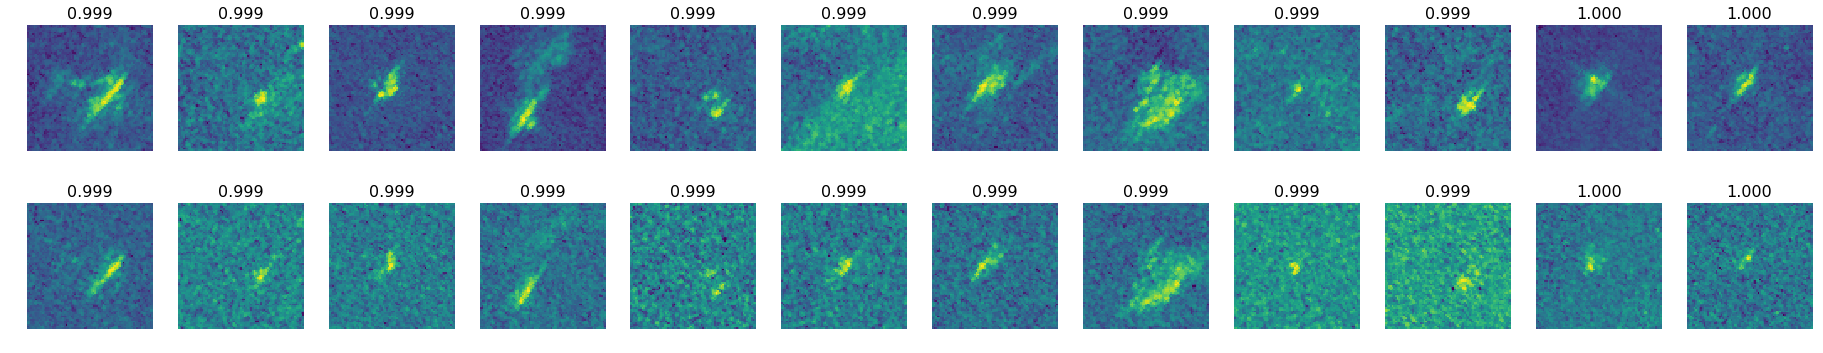

In [15]:
sample_predictions(np.argsort(train_predictions)[np.isin(np.argsort(train_predictions), correct)][-12:])

#### Most confident (and wrong)

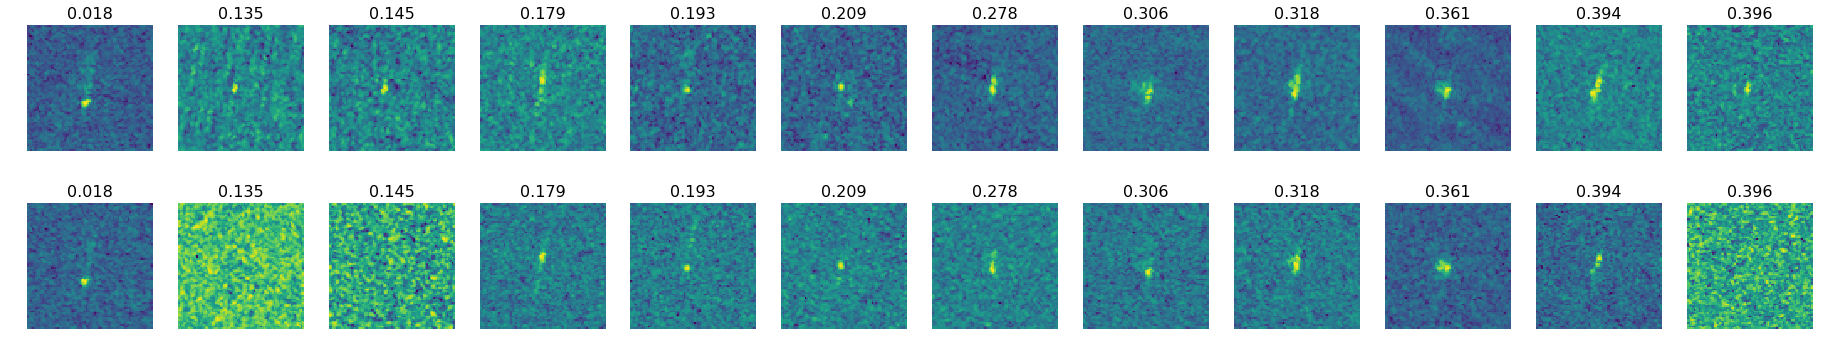

In [16]:
sample_predictions(np.argsort(train_predictions)[np.isin(np.argsort(train_predictions), wrong)][:12])

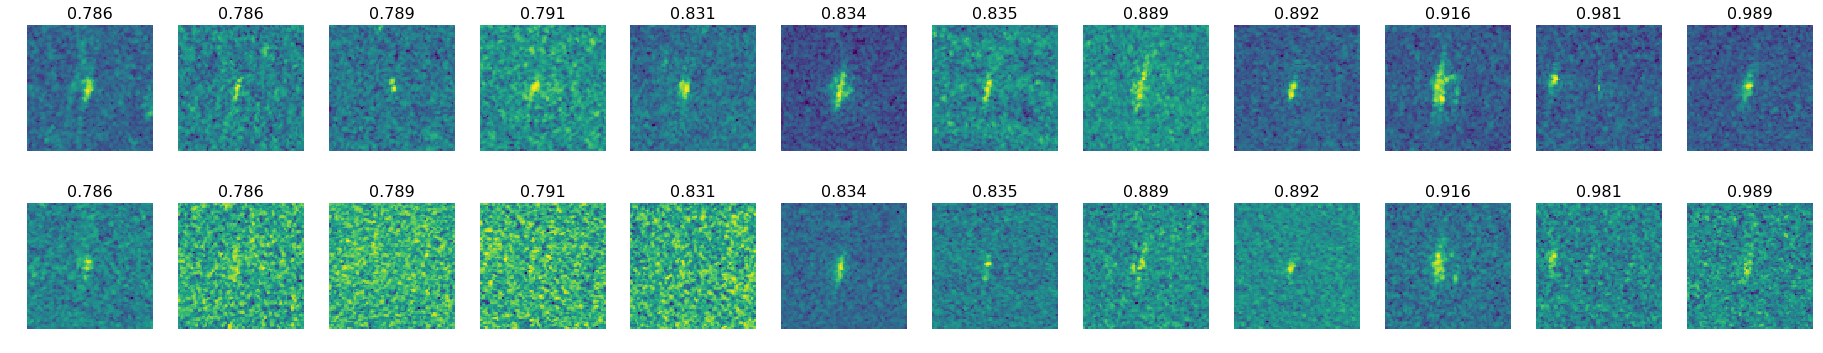

In [17]:
sample_predictions(np.argsort(train_predictions)[np.isin(np.argsort(train_predictions), wrong)][-12:])

#### Some predictions on test data

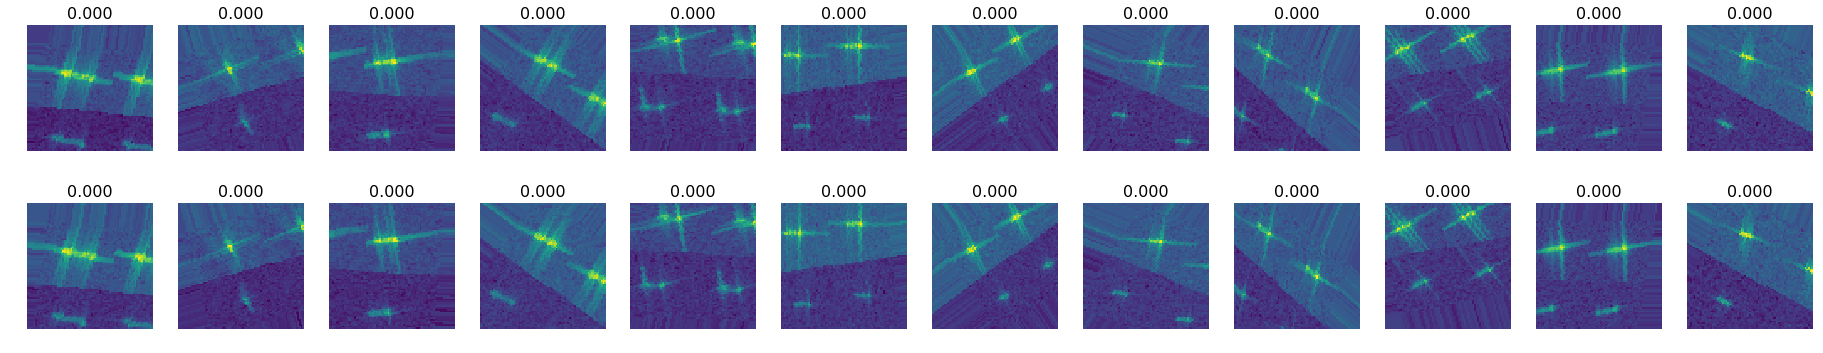

In [7]:
test_predictions = np.load(PATH+'models/aug_cnn_30_tuned.npy')

idx = np.argsort(test_predictions)[:12]
show_imgs(x_test_band[idx], labels=['%.3f'%v for v in test_predictions[idx]])

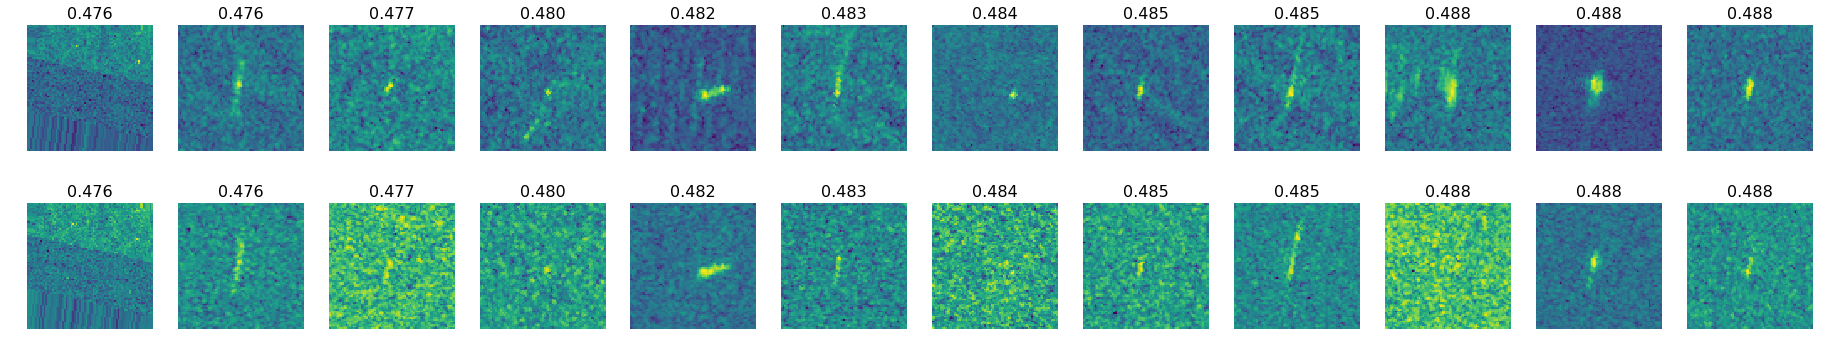

In [8]:
idx = np.argsort(test_predictions)[6500:6512]
show_imgs(x_test_band[idx], labels=['%.3f'%v for v in test_predictions[idx]])

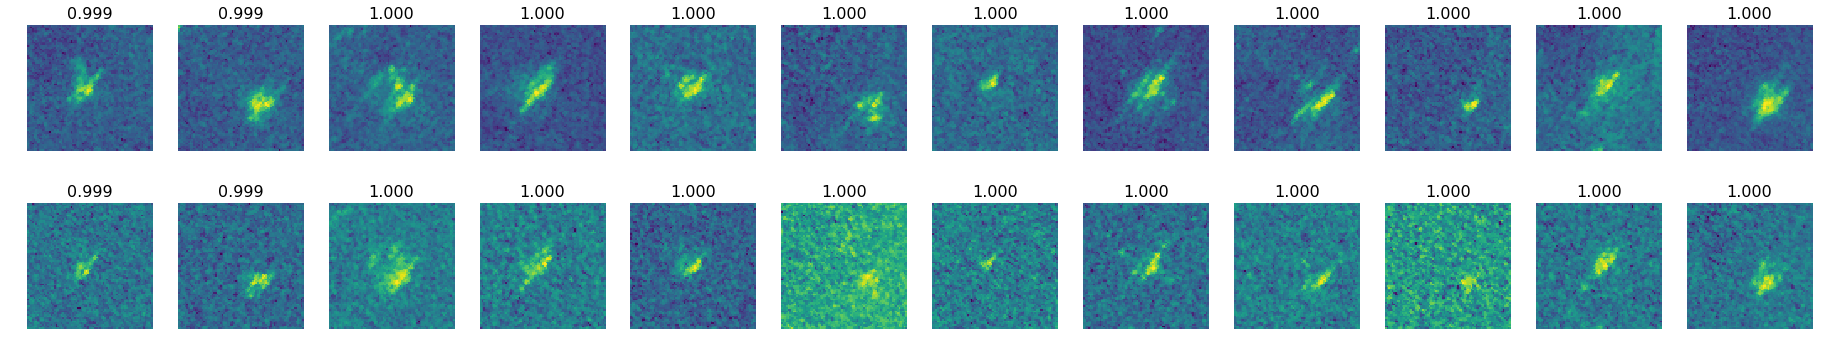

In [9]:
idx = np.argsort(test_predictions)[-12:]
show_imgs(x_test_band[idx], labels=['%.3f'%v for v in test_predictions[idx]])

### Retraining with pseudo-labels

In [3]:
def get_pseudo_batches(imgs, angles, labels, percent_pseudo=0.2, batch_size=32, rotate=None, translate=None, zoom=None, channel_shift=None, flip=None):
    imgs, pseudo_imgs = imgs
    angles, pseudo_angles = angles
    labels, pseudo_labels = labels
    
    combined_imgs = np.concatenate([imgs, pseudo_imgs])
    combined_angles = np.concatenate([angles, pseudo_angles])
    combined_labels = np.concatenate([labels, pseudo_labels])
    
    while True:
        indices = np.random.permutation(
            np.concatenate([
                list(range(len(labels))),
                np.random.permutation(
                    list(range(len(pseudo_labels)))
                )[:int(len(labels)*percent_pseudo)] + len(labels),    
            ]))

        combined_imgs = np.copy(combined_imgs)
        combined_angles = np.copy(combined_angles)
        combined_labels = np.copy(combined_labels)
        
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            
            img_batch = []
            meta_batch = []
            label_batch = combined_labels[indices[start:end]]
            
            for _i in range(start, end):
                i = indices[_i]
                
                img, meta = aug_img(combined_imgs[i], rotate=rotate, translate=translate, zoom=zoom, channel_shift=channel_shift, flip=flip)
                meta.append(combined_angles[i])

                img_batch.append(img)
                meta_batch.append(meta)
            
            meta_batch = np.array(meta_batch, np.float32)
            img_batch = np.array(img_batch, np.float32)
            
            yield [img_batch, meta_batch], label_batch

In [6]:
model = get_model()
model.fit_generator(
    get_pseudo_batches(
        (x_train_band, x_test_band), (x_train_angle, x_test_angle), (y_train, np.load(PATH+'models/aug_cnn_30_tuned.npy')),
        percent_pseudo=0.25, batch_size=32
    ),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/32), epochs=10
)
model.save(PATH+'models/pseudo_10.h5')
model.save_weights(PATH+'models/pseudo_weights.h5')

Epoch 1/10
41/41 [==============================] - 36s - loss: 0.4424 - acc: 0.6242 - val_loss: 0.3514 - val_acc: 0.8505
Epoch 2/10
41/41 [==============================] - 27s - loss: 0.3094 - acc: 0.6928 - val_loss: 0.2358 - val_acc: 0.9221
Epoch 3/10
41/41 [==============================] - 27s - loss: 0.2600 - acc: 0.7076 - val_loss: 0.2207 - val_acc: 0.9221
Epoch 4/10
41/41 [==============================] - 27s - loss: 0.2489 - acc: 0.7381 - val_loss: 0.3023 - val_acc: 0.8692
Epoch 5/10
41/41 [==============================] - 27s - loss: 0.2667 - acc: 0.7134 - val_loss: 0.2933 - val_acc: 0.8660
Epoch 6/10
41/41 [==============================] - 27s - loss: 0.2157 - acc: 0.7454 - val_loss: 0.2339 - val_acc: 0.8941
Epoch 7/10
41/41 [==============================] - 27s - loss: 0.1805 - acc: 0.7408 - val_loss: 0.2146 - val_acc: 0.9097
Epoch 8/10
41/41 [==============================] - 27s - loss: 0.1730 - acc: 0.7648 - val_loss: 0.3069 - val_acc: 0.8692
Epoch 9/10
41/41 [======

#### Kicking the learning rate

Our model improved when decreasing the learning rate earlier - maybe kicking it up & down will lead to even better results?

In [13]:
model = get_model(optimizer=SGD(lr=0.00001))
model.load_weights(PATH+'models/pseudo_weights.h5')
model.fit_generator(
    get_pseudo_batches(
        (x_train_band, x_test_band), (x_train_angle, x_test_angle), (y_train, np.load(PATH+'models/aug_cnn_30_tuned.npy')),
        percent_pseudo=0.25, batch_size=64
    ),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/64), epochs=1
)
model.save(PATH+'models/pseudo_11.h5')
model.save_weights(PATH+'models/pseudo_weights.h5')

Epoch 1/1
21/21 [==============================] - 29s - loss: 0.1267 - acc: 0.7738 - val_loss: 0.2242 - val_acc: 0.9190


In [14]:
model = get_model(optimizer=SGD(lr=0.001))
model.load_weights(PATH+'models/pseudo_weights.h5')
model.fit_generator(
    get_pseudo_batches(
        (x_train_band, x_test_band), (x_train_angle, x_test_angle), (y_train, np.load(PATH+'models/aug_cnn_30_tuned.npy')),
        percent_pseudo=0.25, batch_size=64
    ),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/64), epochs=1
)
model.save(PATH+'models/pseudo_12.h5')
model.save_weights(PATH+'models/pseudo_weights.h5')

Epoch 1/1
21/21 [==============================] - 29s - loss: 0.1186 - acc: 0.7865 - val_loss: 0.2288 - val_acc: 0.9065


In [15]:
model = get_model(optimizer=Adam(lr=0.0001))
model.load_weights(PATH+'models/pseudo_weights.h5')
model.fit_generator(
    get_pseudo_batches(
        (x_train_band, x_test_band), (x_train_angle, x_test_angle), (y_train, np.load(PATH+'models/aug_cnn_30_tuned.npy')),
        percent_pseudo=0.25, batch_size=64
    ),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/64), epochs=1
)
model.save(PATH+'models/pseudo_13.h5')
model.save_weights(PATH+'models/pseudo_weights.h5')

Epoch 1/1
21/21 [==============================] - 29s - loss: 0.1232 - acc: 0.7805 - val_loss: 0.2655 - val_acc: 0.8910


#### Bringing back augmentation

We're starting to overfit with our pseudo-labels - let's bring back data augmentation for a final 7 epochs

In [17]:
model = get_model(optimizer=Adam(lr=0.0001))
model.load_weights(PATH+'models/pseudo_weights.h5')
model.fit_generator(
    get_pseudo_batches(
        (x_train_band, x_test_band), (x_train_angle, x_test_angle), (y_train, np.load(PATH+'models/aug_cnn_30_tuned.npy')),
        rotate=20, translate=0.2, zoom=(0.7,1.3), channel_shift=0.4,
        percent_pseudo=0.25, batch_size=64
    ),
    validation_data=([x_valid_band, x_valid_meta], y_valid),
    steps_per_epoch=np.ceil(len(y_train)/64), epochs=7
)
model.save(PATH+'models/pseudo_20.h5')

Epoch 1/7
21/21 [==============================] - 29s - loss: 0.2696 - acc: 0.7143 - val_loss: 0.2743 - val_acc: 0.8816
Epoch 2/7
21/21 [==============================] - 26s - loss: 0.2880 - acc: 0.7109 - val_loss: 0.2194 - val_acc: 0.9315
Epoch 3/7
21/21 [==============================] - 27s - loss: 0.2811 - acc: 0.6982 - val_loss: 0.2285 - val_acc: 0.9159
Epoch 4/7
21/21 [==============================] - 27s - loss: 0.2346 - acc: 0.6823 - val_loss: 0.2391 - val_acc: 0.9097
Epoch 5/7
21/21 [==============================] - 27s - loss: 0.2486 - acc: 0.7313 - val_loss: 0.2221 - val_acc: 0.9003
Epoch 6/7
21/21 [==============================] - 28s - loss: 0.2245 - acc: 0.7277 - val_loss: 0.2081 - val_acc: 0.9190
Epoch 7/7
21/21 [==============================] - 27s - loss: 0.2768 - acc: 0.7027 - val_loss: 0.2303 - val_acc: 0.8941


## Submission & conclusion

Our pseudo-label approach didn't seem to improve performance much (at all?) - although the model could be improved further I'm feeling a little bored and ready to make a submission.

If I were so inclined, further experimentation could include: augmentation with gaussian noise, ensembling & including the validation set for a final epoch.

In [28]:
df = pd.DataFrame({'id': test_ids, 'is_iceberg': test_predictions})
df['is_iceberg'] = df['is_iceberg'].clip(0.01, 0.99)
df.to_csv(PATH+'submission_1.csv', index=False)